#  Data Wrangling

Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

Set global variables

In [2]:
NUMBER=540

Get names of companies and data sources

In [3]:
# Read list of company names
companies = pd.read_csv('data/companies.csv', header=None).squeeze("columns")
# Read list of data source names
data_sources = ['key-metrics', 'income-statement', 'financial-growth', 'ratios']

Join each company for each method into a single dataframe (concatenate rows)

In [4]:
for data_source in data_sources:
    frames = []
    for company in companies[:NUMBER]:
        # Append rows of dataframes in list
        frames.append(pd.read_csv('data/' + data_source + '/' + company + '.csv'))
    # Persist updated dataframe
    data = pd.concat(frames)
    data.to_csv('data/' + data_source + '.csv', index=False)

Join each data source into a single dataframe (concatenate columns). 

In [5]:
frames = []
for data_source in data_sources:
    # Read data source and append to list
    frames.append(pd.read_csv('data/' + data_source + '.csv'))
# Concatenate columns of dataframes in list
data = pd.concat(frames, axis=1)
# Remove any duplicate columns
data = data.loc[:,~data.columns.duplicated()]
# Drop empty rows at the end of the data frame
data = data.dropna(subset=['symbol'])
# Round data to 4 decimal places
numeric_columns = data.select_dtypes(include=['number']).columns
data[numeric_columns] = data[numeric_columns].round(4)
# Convert string representation to datetime data type
data['date'] = pd.to_datetime(data['date'])
# Filter for the year 2019
data = data[data['date'].dt.year == 2019]
# Drop non-numeric rows (datetimes and strings)
data.drop(['date','fillingDate', 'acceptedDate', 'period', 'link', 'finalLink'], axis=1, inplace=True)

Find differences in stock and company names.

In [6]:
companies = set(data['symbol'].reset_index(drop=True))
stocks = pd.read_csv('data/stocks.csv', header=None).squeeze("columns")

Calculate annual stock price growth. 

In [7]:
frames = []
for stock in stocks[:NUMBER]:
    prices = pd.read_csv('data/historical-price/' + stock + '.csv')
    prices['Date'] = pd.to_datetime(prices['Date'])
    prices_filtered = prices[prices['Date'].dt.year != 2020]
    
    if len(prices_filtered) > 0:
        # Ensure there are at least two rows to calculate share growth
        if len(prices_filtered) > 1:
            share_growth = (prices_filtered.tail(1)['Close'].iloc[0] - prices_filtered.head(1)['Close'].iloc[0]) / prices_filtered.head(1)['Close'].iloc[0]
        else:
            # Handle case where there's only one row left after filtering
            share_growth = 0  # or set it to NaN or some default value
    else:
        # Handle case where there are no rows left after filtering
        share_growth = 0  # or set it to NaN or some default value
    
    frames.append(pd.DataFrame({'symbol': stock.replace('-', ''), 'shareGrowth': share_growth}, index=[stock.replace('-', '')]))

historical_price = pd.concat(frames).reset_index(drop=True)
historical_price.to_csv('data/historical-price.csv', index=False)
data = pd.merge(data, historical_price, on='symbol', how='outer')
data.to_csv('data/data.csv', index=False)
# Set 'symbol' as the index
data.set_index('symbol', inplace=True)

In [8]:
#check the data frame
data

,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,tangibleBookValuePerShare,shareholdersEquityPerShare,interestDebtPerShare,marketCap,...,priceToBookRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,enterpriseValueMultiple,priceFairValue,shareGrowth
symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,13.9911,2.9714,3.7316,3.1672,2.6266,4.8661,18.2040,4.8661,5.4509,1.157812e+12,...,12.7952,20.9536,19.6586,16.6853,16.6853,7.0516,4.4501,14.7417,12.7952,0.307494
MSFT,16.4008,5.1140,6.8011,4.9863,1.4800,13.3364,30.8589,13.3364,9.8534,1.061250e+12,...,10.3709,27.0451,27.7378,20.3363,20.3363,5.2884,8.4331,19.3402,10.3709,0.150507
AMZN,556.5913,22.9921,76.4167,42.9623,71.6111,123.1349,409.6131,123.1349,83.5496,9.428228e+11,...,15.1921,81.3620,43.5424,24.4800,24.4800,4.0709,3.3610,25.3605,15.1921,0.064639
FB,24.5817,6.4273,12.6266,7.3755,6.6339,35.1370,39.5574,35.1370,0.1523,6.026083e+11,...,5.9632,32.5999,28.4088,16.5944,16.5944,4.2401,8.5238,19.1001,5.9632,0.167454
GOOGL,231.7023,49.1628,78.0467,44.3372,26.4803,288.3692,362.6137,288.3692,6.6623,1.015875e+12,...,5.0430,29.5803,32.7998,18.6331,18.6331,0.6723,6.2764,19.4527,5.0430,0.110605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LUMN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
PTON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.261661
WORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.017053


In [9]:
#Examine the data frame
data.info()
data.describe()
data.isnull().sum()
data.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 545 entries, AAPL to HEIA
Columns: 161 entries, revenuePerShare to shareGrowth
dtypes: float64(161)
memory usage: 689.8+ KB


,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,tangibleBookValuePerShare,shareholdersEquityPerShare,interestDebtPerShare,marketCap,...,priceToBookRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,enterpriseValueMultiple,priceFairValue,shareGrowth
count,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,5.230000e+02,...,5.230000e+02,5.230000e+02,5.350000e+02,5.230000e+02,5.230000e+02,5.200000e+02,5.230000e+02,5.290000e+02,5.230000e+02,541.000000
mean,391.002960,107.923990,61.886751,36.875358,36.377586,542.320580,990.693554,542.320580,112.805971,4.852419e+13,...,3.108892e+05,1.997958e+06,-2.841351e+05,2.497644e+05,2.497644e+05,3.641353e+13,3.503325e+04,3.108558e+05,3.108892e+05,0.100879
std,6855.230483,2183.693221,1048.910295,615.603575,467.487552,11369.997012,18901.132601,11369.997012,1332.659854,7.832374e+14,...,6.877767e+06,4.498285e+07,7.136472e+06,5.316868e+06,5.316868e+06,8.302852e+14,7.126983e+05,6.748726e+06,6.877767e+06,0.131055
min,-1.388300,-14.473500,-16.161800,-21.082900,0.000000,-83.793800,0.000000,-83.793800,-0.031200,5.004191e+07,...,-2.043372e+03,-1.150846e+03,-1.645812e+08,-1.519240e+02,-1.519240e+02,-1.227301e+04,-6.543200e+00,-1.675750e+03,-2.043372e+03,-0.294741
25%,15.105800,1.865750,3.255850,1.402850,1.207000,10.575650,20.108300,10.575650,7.197150,1.308473e+10,...,2.008550e+00,1.266635e+01,9.803150e+00,9.714100e+00,9.714100e+00,2.459075e+00,1.702250e+00,9.734500e+00,2.008550e+00,0.013838
50%,28.824900,3.765800,6.042600,3.833400,3.043400,19.714300,38.417500,19.714300,17.222100,2.274323e+10,...,3.829000e+00,2.230990e+01,2.123920e+01,1.666750e+01,1.666750e+01,6.059700e+00,3.499000e+00,1.533490e+01,3.829000e+00,0.092471
75%,57.897800,6.282050,10.093800,6.886650,6.776450,38.944950,94.692350,38.944950,35.530450,4.801375e+10,...,7.964300e+00,3.432470e+01,3.323360e+01,2.475965e+01,2.475965e+01,1.451505e+01,6.593550e+00,2.166080e+01,7.964300e+00,0.166409
max,155828.895200,49828.452100,23677.037100,13897.644100,9182.678000,259978.603900,431345.956400,259978.603900,25429.849000,1.338214e+16,...,1.572087e+08,1.028633e+09,1.234515e+07,1.212616e+08,1.212616e+08,1.893342e+16,1.616383e+07,1.549629e+08,1.572087e+08,0.709633


revenuePerShare               22
netIncomePerShare             22
operatingCashFlowPerShare     22
freeCashFlowPerShare          22
cashPerShare                  22
                              ..
priceEarningsToGrowthRatio    25
priceSalesRatio               22
enterpriseValueMultiple       16
priceFairValue                22
shareGrowth                    4
Length: 161, dtype: int64

0

Examine missing, zero and negative numbers

In [10]:
#Columns with missing data %
percent_missing_columns = data.isnull().sum() * 100 / len(data)
percent_missing_columns_df = pd.DataFrame({'column_name': data.columns,
                                           'percent_missing': percent_missing_columns})
percent_missing_columns_df.sort_values('percent_missing', ascending=False, inplace=True)
print(percent_missing_columns_df.head(20))

#Rows with missing data %
percent_missing_rows = data.isnull().sum(axis=1) * 100 / data.shape[1]
percent_missing_rows_df = pd.DataFrame({'row_name': percent_missing_rows.index,
                                           'percent_missing': percent_missing_rows})
percent_missing_rows_df.sort_values('percent_missing', ascending=False, inplace=True)
print(percent_missing_rows_df.head(20))

#Create seperate data frame to anaylse numbers for zeros
numeric_data = data.select_dtypes(include=['number'])

#Reviewing column names with zero or negative values
columns_with_zero_orless = numeric_data.le(0).any(axis=0)
columns_with_zero_orless = columns_with_zero_orless[columns_with_zero_orless].index.tolist()
print("Columns that contain the value zero or less:")
print(columns_with_zero_orless)

#Columns with the most zeros
columns_with_zero = numeric_data.eq(0).sum(axis=0) * 100 /len(data)
columns_with_zero_df = pd.DataFrame({'column_name': numeric_data.columns,
                                           'zero_values': columns_with_zero})
columns_with_zero_df.sort_values('zero_values', ascending=False, inplace=True)
print(columns_with_zero_df.head(20))

# Drop NaN in target column
data = data.dropna(subset=['shareGrowth'])


                                                         column_name  \
investedCapital                                      investedCapital   
cashFlowToDebtRatio                              cashFlowToDebtRatio   
totalDebtToCapitalization                  totalDebtToCapitalization   
cashFlowCoverageRatios                        cashFlowCoverageRatios   
shortTermCoverageRatios                      shortTermCoverageRatios   
averageInventory                                    averageInventory   
inventoryTurnover                                  inventoryTurnover   
dividendPaidAndCapexCoverageRatio  dividendPaidAndCapexCoverageRatio   
dividendPayoutRatio                              dividendPayoutRatio   
dividendYield                                          dividendYield   
cashConversionCycle                              cashConversionCycle   
averagePayables                                      averagePayables   
daysOfPayablesOutstanding                  daysOfPayablesOutstan

Drop columns and rows with >50% data missing and column with 100% zeros

In [11]:
#Drop columns with missing data >50%
data = data.dropna(thresh=data.shape[0]*0.5, axis=1)

#Drop rows with missing data >50%
data = data.dropna(thresh=data.shape[1]*0.5, axis=0)

#Drop bookValueperShareGrowth as the whole column has the same value
data.drop(columns=['bookValueperShareGrowth'], inplace=True)

#To confirm rows dropped
data

,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,tangibleBookValuePerShare,shareholdersEquityPerShare,interestDebtPerShare,marketCap,...,priceToBookRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,enterpriseValueMultiple,priceFairValue,shareGrowth
symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,13.9911,2.9714,3.7316,3.1672,2.6266,4.8661,18.2040,4.8661,5.4509,1.157812e+12,...,12.7952,20.9536,19.6586,16.6853,16.6853,7.0516,4.4501,14.7417,12.7952,0.307494
MSFT,16.4008,5.1140,6.8011,4.9863,1.4800,13.3364,30.8589,13.3364,9.8534,1.061250e+12,...,10.3709,27.0451,27.7378,20.3363,20.3363,5.2884,8.4331,19.3402,10.3709,0.150507
AMZN,556.5913,22.9921,76.4167,42.9623,71.6111,123.1349,409.6131,123.1349,83.5496,9.428228e+11,...,15.1921,81.3620,43.5424,24.4800,24.4800,4.0709,3.3610,25.3605,15.1921,0.064639
FB,24.5817,6.4273,12.6266,7.3755,6.6339,35.1370,39.5574,35.1370,0.1523,6.026083e+11,...,5.9632,32.5999,28.4088,16.5944,16.5944,4.2401,8.5238,19.1001,5.9632,0.167454
GOOGL,231.7023,49.1628,78.0467,44.3372,26.4803,288.3692,362.6137,288.3692,6.6623,1.015875e+12,...,5.0430,29.5803,32.7998,18.6331,18.6331,0.6723,6.2764,19.4527,5.0430,0.110605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RE,181.4979,24.7834,45.4687,45.4687,19.8382,224.2236,670.8363,224.2236,16.3394,1.104050e+10,...,1.2089,10.9370,5.9614,5.9614,5.9614,5.0031,1.4934,9.6104,1.2089,0.049232
SNA,72.7674,12.4061,12.0680,10.2898,3.3005,60.9857,81.1413,60.9857,19.3953,9.011158e+09,...,2.6433,12.9937,15.6661,13.3578,13.3578,1.0474,2.2153,10.4984,2.6433,0.094457
SNA,73.9582,12.6091,12.2655,10.4582,3.3545,61.9836,82.4691,61.9836,21.9782,8.763860e+09,...,2.5707,12.6371,15.2362,12.9912,12.9912,1.0022,2.1545,9.3046,2.5707,0.094457


Check Low and High Variance


Column debtToAssets might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([ 8.,  6., 20., 14., 25., 33., 56., 71., 75., 79., 53., 58., 15.,
        12.,  3.,  3.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.]),
 array([0.10562048, 0.15202318, 0.19842589, 0.24482859, 0.29123129,
        0.33763399, 0.3840367 , 0.4304394 , 0.4768421 , 0.5232448 ,
        0.56964751, 0.61605021, 0.66245291, 0.70885562, 0.75525832,
        0.80166102, 0.84806372, 0.89446643, 0.94086913, 0.98727183,
        1.03367453, 1.08007724, 1.12647994, 1.17288264, 1.21928534,
        1.26568805, 1.31209075, 1.35849345, 1.40489615, 1.45129886,
        1.49770156]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column debtToAssets')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

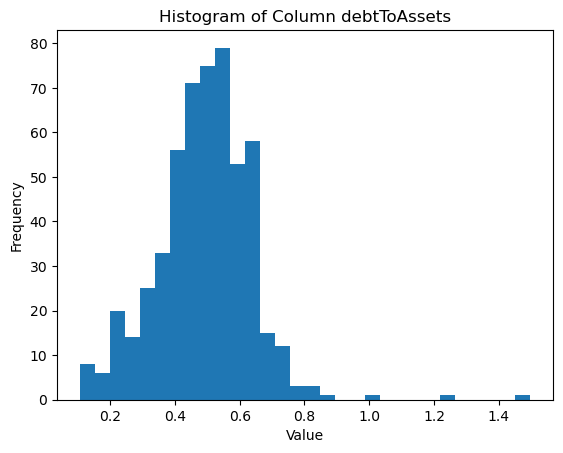


Column salesGeneralAndAdministrativeToRevenue might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([  2.,   0.,   0.,   0.,   0.,   1., 402.,   9.,   5.,  10.,   6.,
          8.,  13.,  14.,   6.,   7.,  10.,   9.,   9.,   2.,   3.,   5.,
          5.,   2.,   3.,   2.,   1.,   0.,   0.,   1.]),
 array([-0.17269201, -0.14790672, -0.12312144, -0.09833615, -0.07355087,
        -0.04876558, -0.0239803 ,  0.00080499,  0.02559027,  0.05037556,
         0.07516084,  0.09994613,  0.12473141,  0.1495167 ,  0.17430198,
         0.19908727,  0.22387255,  0.24865784,  0.27344312,  0.29822841,
         0.32301369,  0.34779898,  0.37258426,  0.39736955,  0.42215484,
         0.44694012,  0.47172541,  0.49651069,  0.52129598,  0.54608126,
         0.57086655]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column salesGeneralAndAdministrativeToRevenue')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

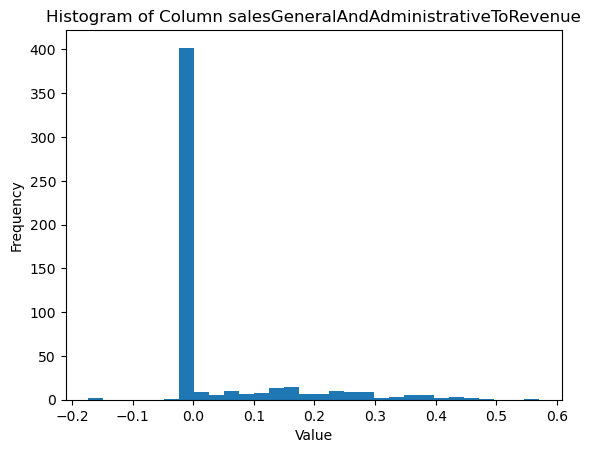


Column intangiblesToTotalAssets might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([130.,  23.,  24.,  24.,  20.,  16.,  19.,   8.,  13.,  17.,  15.,
         15.,  11.,   6.,  15.,  16.,  22.,  15.,  15.,  17.,  17.,  13.,
         14.,   8.,  15.,  10.,   6.,   3.,   5.,   3.]),
 array([0.        , 0.02129674, 0.04259348, 0.06389022, 0.08518696,
        0.10648369, 0.12778043, 0.14907717, 0.17037391, 0.19167065,
        0.21296739, 0.23426413, 0.25556087, 0.27685761, 0.29815434,
        0.31945108, 0.34074782, 0.36204456, 0.3833413 , 0.40463804,
        0.42593478, 0.44723152, 0.46852825, 0.48982499, 0.51112173,
        0.53241847, 0.55371521, 0.57501195, 0.59630869, 0.61760543,
        0.63890217]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column intangiblesToTotalAssets')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

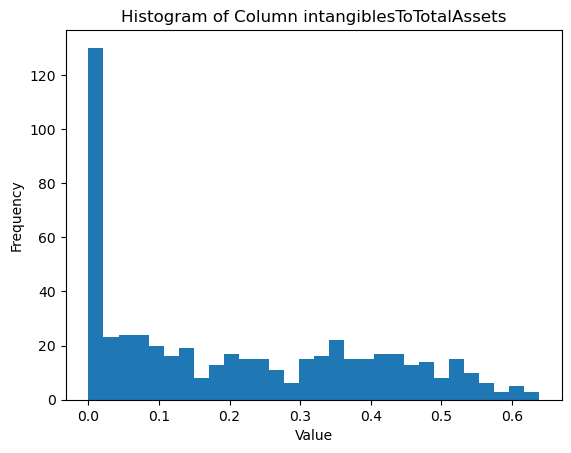


Column stockBasedCompensationToRevenue might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([402.,  60.,  35.,  11.,  10.,   2.,   6.,   3.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([-0.00697561,  0.0216991 ,  0.05037381,  0.07904852,  0.10772323,
         0.13639794,  0.16507266,  0.19374737,  0.22242208,  0.25109679,
         0.2797715 ,  0.30844621,  0.33712092,  0.36579564,  0.39447035,
         0.42314506,  0.45181977,  0.48049448,  0.50916919,  0.5378439 ,
         0.56651862,  0.59519333,  0.62386804,  0.65254275,  0.68121746,
         0.70989217,  0.73856689,  0.7672416 ,  0.79591631,  0.82459102,
         0.85326573]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column stockBasedCompensationToRevenue')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

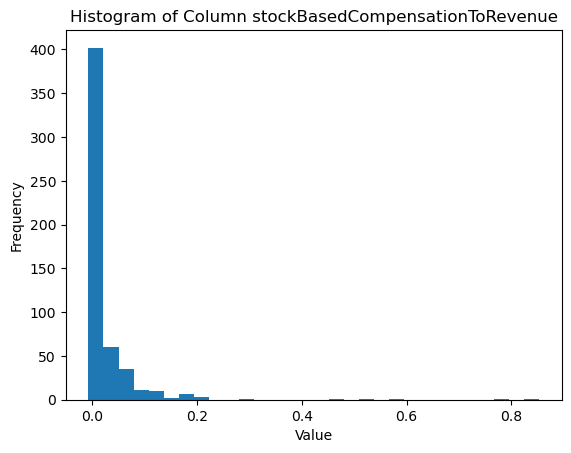


Column roic might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([  1.,   0.,   1.,   0.,   1.,   0.,   1.,   3.,   2.,   1.,   1.,
          3.,   3.,  10.,  15.,  46., 113., 113.,  75.,  65.,  27.,  23.,
         17.,   2.,   5.,   4.,   0.,   0.,   0.,   1.]),
 array([-0.660159  , -0.61758092, -0.57500283, -0.53242474, -0.48984665,
        -0.44726856, -0.40469048, -0.36211239, -0.3195343 , -0.27695621,
        -0.23437812, -0.19180003, -0.14922195, -0.10664386, -0.06406577,
        -0.02148768,  0.02109041,  0.06366849,  0.10624658,  0.14882467,
         0.19140276,  0.23398085,  0.27655894,  0.31913702,  0.36171511,
         0.4042932 ,  0.44687129,  0.48944938,  0.53202747,  0.57460555,
         0.61718364]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column roic')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

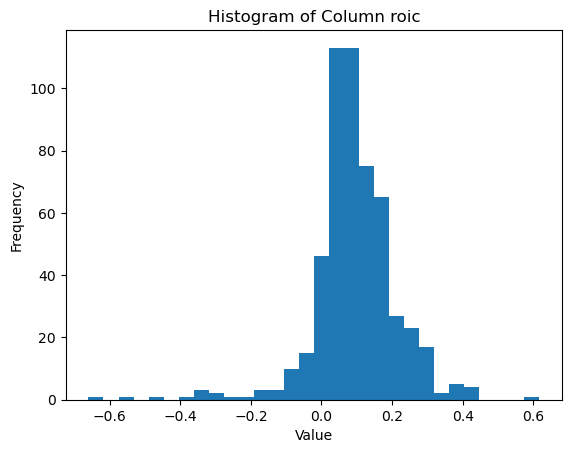


Column returnOnTangibleAssets might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([ 1.,  0.,  0.,  1.,  1.,  4.,  2.,  0.,  1.,  4.,  4.,  9., 12.,
        18., 94., 75., 71., 62., 57., 40., 31., 24., 11.,  7.,  3.,  2.,
         0.,  0.,  0.,  1.]),
 array([-0.45253952, -0.42029494, -0.38805037, -0.35580579, -0.32356122,
        -0.29131664, -0.25907207, -0.22682749, -0.19458292, -0.16233834,
        -0.13009377, -0.09784919, -0.06560462, -0.03336004, -0.00111547,
         0.0311291 ,  0.06337368,  0.09561825,  0.12786283,  0.1601074 ,
         0.19235198,  0.22459655,  0.25684113,  0.2890857 ,  0.32133028,
         0.35357485,  0.38581943,  0.418064  ,  0.45030858,  0.48255315,
         0.51479772]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column returnOnTangibleAssets')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

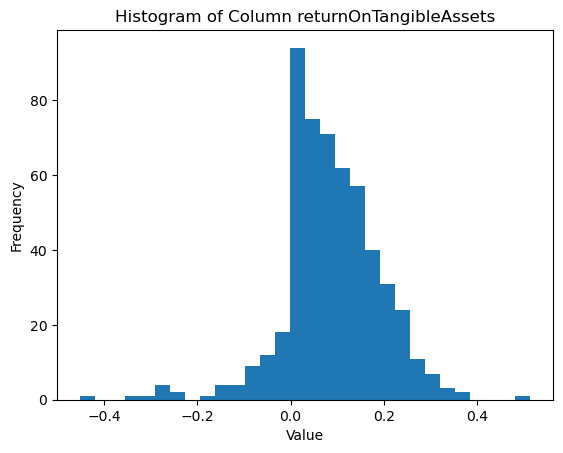


Column grossProfitRatio might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([ 7.,  2.,  4.,  2.,  3., 12., 10., 15.,  9., 17., 17., 20., 20.,
        16., 24., 23., 31., 19., 26., 24., 21., 29., 25., 25., 17., 17.,
        18., 12.,  7., 55.]),
 array([0.        , 0.02310491, 0.04620981, 0.06931472, 0.09241962,
        0.11552453, 0.13862944, 0.16173434, 0.18483925, 0.20794415,
        0.23104906, 0.25415397, 0.27725887, 0.30036378, 0.32346868,
        0.34657359, 0.3696785 , 0.3927834 , 0.41588831, 0.43899321,
        0.46209812, 0.48520303, 0.50830793, 0.53141284, 0.55451774,
        0.57762265, 0.60072756, 0.62383246, 0.64693737, 0.67004227,
        0.69314718]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column grossProfitRatio')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

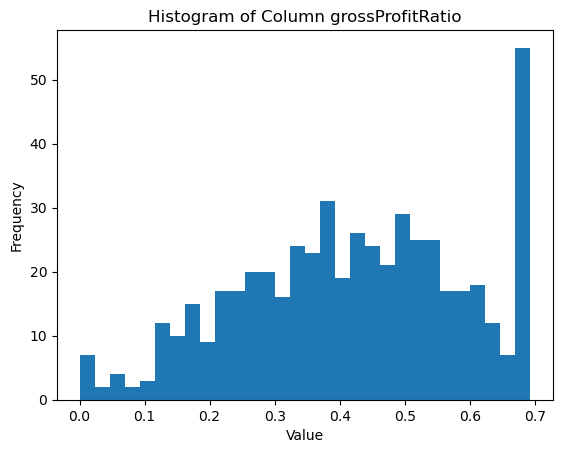


Column revenueGrowth might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([  1.,   0.,   0.,   1.,   2.,   5.,   2.,   7.,  12.,  32.,  96.,
        159.,  90.,  45.,  25.,  14.,  11.,   7.,   6.,   2.,   4.,   4.,
          3.,   2.,   0.,   3.,   0.,   0.,   1.,   1.]),
 array([-0.69144573, -0.62767274, -0.56389975, -0.50012676, -0.43635378,
        -0.37258079, -0.3088078 , -0.24503481, -0.18126182, -0.11748883,
        -0.05371584,  0.01005715,  0.07383014,  0.13760313,  0.20137612,
         0.26514911,  0.3289221 ,  0.39269509,  0.45646808,  0.52024107,
         0.58401406,  0.64778705,  0.71156004,  0.77533303,  0.83910602,
         0.90287901,  0.966652  ,  1.03042499,  1.09419798,  1.15797097,
         1.22174396]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column revenueGrowth')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

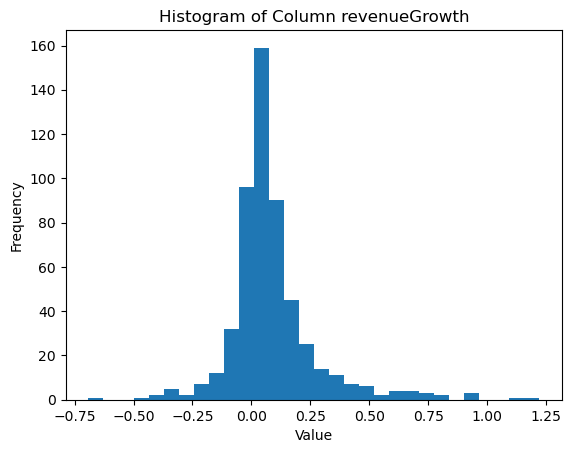


Column inventoryGrowth might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([  1.,   4.,   2.,   4.,   3.,  11.,  30.,  41., 285.,  70.,  33.,
         12.,   7.,  10.,   5.,   6.,   1.,   5.,   0.,   1.,   0.,   1.,
          0.,   1.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([-0.56434743, -0.49446358, -0.42457974, -0.35469589, -0.28481204,
        -0.21492819, -0.14504434, -0.07516049, -0.00527664,  0.0646072 ,
         0.13449105,  0.2043749 ,  0.27425875,  0.3441426 ,  0.41402645,
         0.4839103 ,  0.55379414,  0.62367799,  0.69356184,  0.76344569,
         0.83332954,  0.90321339,  0.97309724,  1.04298108,  1.11286493,
         1.18274878,  1.25263263,  1.32251648,  1.39240033,  1.46228418,
         1.53216802]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column inventoryGrowth')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

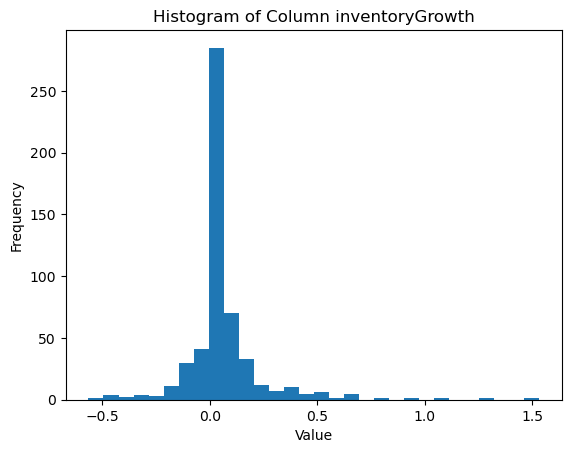


Column bookValueperShareGrowth might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 535.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([-0.5       , -0.46666667, -0.43333333, -0.4       , -0.36666667,
        -0.33333333, -0.3       , -0.26666667, -0.23333333, -0.2       ,
        -0.16666667, -0.13333333, -0.1       , -0.06666667, -0.03333333,
         0.        ,  0.03333333,  0.06666667,  0.1       ,  0.13333333,
         0.16666667,  0.2       ,  0.23333333,  0.26666667,  0.3       ,
         0.33333333,  0.36666667,  0.4       ,  0.43333333,  0.46666667,
         0.5       ]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column bookValueperShareGrowth')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

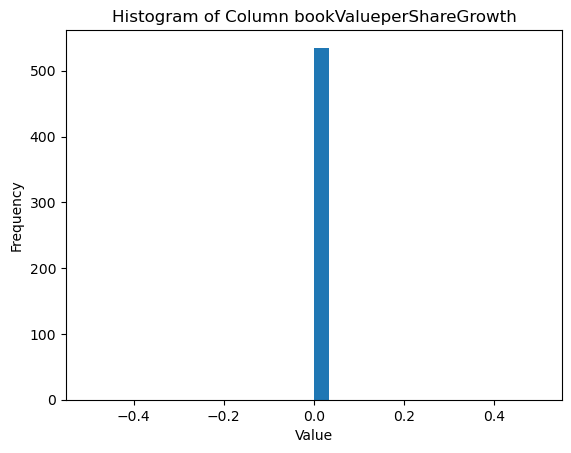


Column rdexpenseGrowth might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([  2.,   0.,   0.,   3.,   1.,   2.,   3.,   4.,   9.,  27., 362.,
         30.,  30.,  18.,  13.,  14.,   4.,   3.,   0.,   1.,   2.,   1.,
          1.,   2.,   1.,   1.,   0.,   0.,   0.,   1.]),
 array([-0.69314718, -0.62637987, -0.55961256, -0.49284525, -0.42607793,
        -0.35931062, -0.29254331, -0.225776  , -0.15900869, -0.09224137,
        -0.02547406,  0.04129325,  0.10806056,  0.17482787,  0.24159519,
         0.3083625 ,  0.37512981,  0.44189712,  0.50866443,  0.57543174,
         0.64219906,  0.70896637,  0.77573368,  0.84250099,  0.9092683 ,
         0.97603562,  1.04280293,  1.10957024,  1.17633755,  1.24310486,
         1.30987217]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column rdexpenseGrowth')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

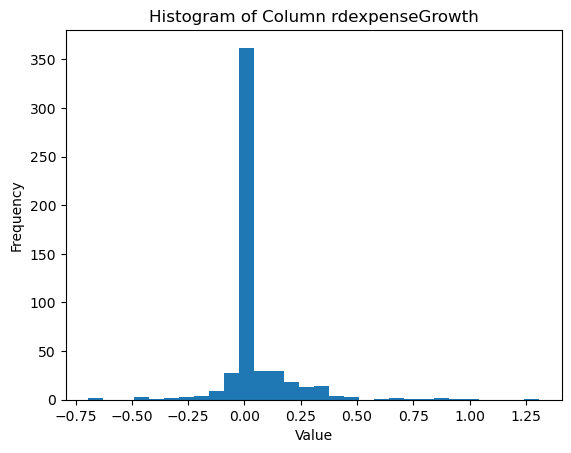


Column sgaexpensesGrowth might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([  1.,   0.,   2.,   0.,   0.,   2.,   3.,   4.,   4.,   8.,  25.,
         47., 132., 117.,  72.,  39.,  23.,  14.,  14.,   2.,   5.,   4.,
          3.,   3.,   0.,   5.,   2.,   1.,   0.,   3.]),
 array([-0.69314718, -0.63781582, -0.58248445, -0.52715309, -0.47182173,
        -0.41649036, -0.361159  , -0.30582764, -0.25049628, -0.19516491,
        -0.13983355, -0.08450219, -0.02917082,  0.02616054,  0.0814919 ,
         0.13682327,  0.19215463,  0.24748599,  0.30281736,  0.35814872,
         0.41348008,  0.46881145,  0.52414281,  0.57947417,  0.63480554,
         0.6901369 ,  0.74546826,  0.80079962,  0.85613099,  0.91146235,
         0.96679371]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column sgaexpensesGrowth')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

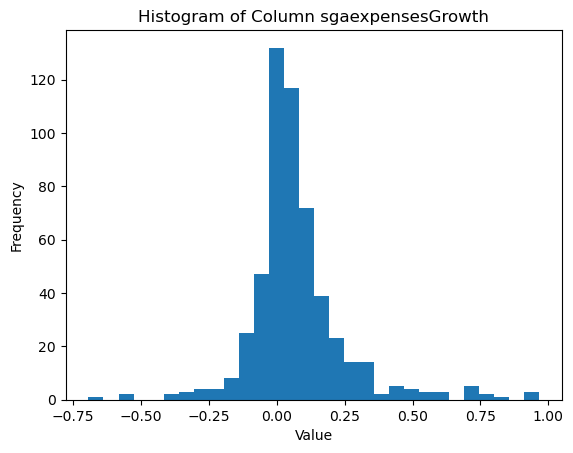


Column returnOnAssets might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([  1.,   0.,   0.,   0.,   1.,   1.,   2.,   0.,   2.,   0.,   1.,
          1.,   1.,   2.,   2.,   7.,  10.,  19.,  59., 115.,  85.,  66.,
         55.,  45.,  22.,   9.,  18.,   5.,   4.,   2.]),
 array([-0.450311  , -0.42578715, -0.4012633 , -0.37673945, -0.3522156 ,
        -0.32769175, -0.3031679 , -0.27864405, -0.2541202 , -0.22959635,
        -0.2050725 , -0.18054865, -0.15602481, -0.13150096, -0.10697711,
        -0.08245326, -0.05792941, -0.03340556, -0.00888171,  0.01564214,
         0.04016599,  0.06468984,  0.08921369,  0.11373754,  0.13826139,
         0.16278523,  0.18730908,  0.21183293,  0.23635678,  0.26088063,
         0.28540448]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column returnOnAssets')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

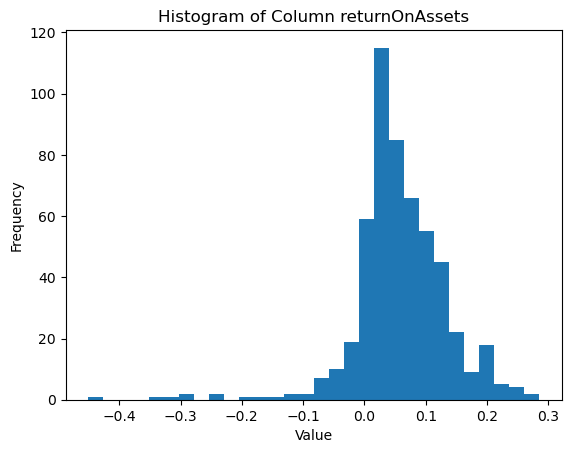


Column returnOnCapitalEmployed might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([  1.,   0.,   1.,   0.,   1.,   0.,   1.,   3.,   2.,   1.,   1.,
          3.,   3.,  10.,  15.,  46., 113., 113.,  75.,  65.,  27.,  23.,
         17.,   2.,   5.,   4.,   0.,   0.,   0.,   1.]),
 array([-0.660159  , -0.61758092, -0.57500283, -0.53242474, -0.48984665,
        -0.44726856, -0.40469048, -0.36211239, -0.3195343 , -0.27695621,
        -0.23437812, -0.19180003, -0.14922195, -0.10664386, -0.06406577,
        -0.02148768,  0.02109041,  0.06366849,  0.10624658,  0.14882467,
         0.19140276,  0.23398085,  0.27655894,  0.31913702,  0.36171511,
         0.4042932 ,  0.44687129,  0.48944938,  0.53202747,  0.57460555,
         0.61718364]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column returnOnCapitalEmployed')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

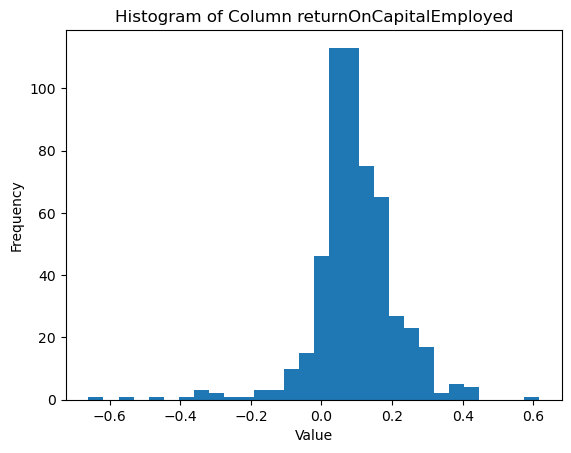


Column ebtPerEbit might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0., 534.]),
 array([0.64783596, 0.64934633, 0.65085671, 0.65236708, 0.65387745,
        0.65538783, 0.6568982 , 0.65840858, 0.65991895, 0.66142932,
        0.6629397 , 0.66445007, 0.66596045, 0.66747082, 0.6689812 ,
        0.67049157, 0.67200194, 0.67351232, 0.67502269, 0.67653307,
        0.67804344, 0.67955381, 0.68106419, 0.68257456, 0.68408494,
        0.68559531, 0.68710568, 0.68861606, 0.69012643, 0.69163681,
        0.69314718]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column ebtPerEbit')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

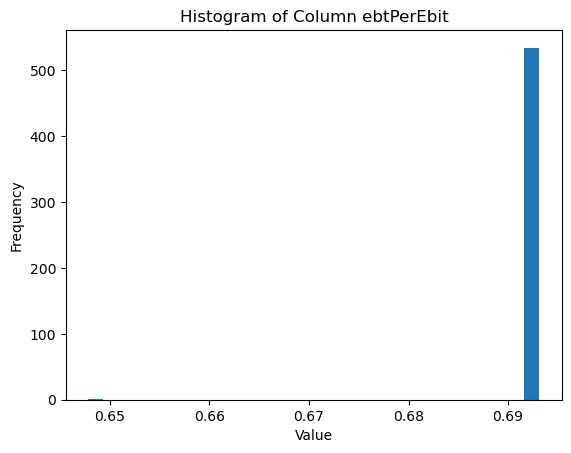


Column debtRatio might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([ 8.,  6., 20., 14., 25., 33., 56., 71., 75., 79., 53., 58., 15.,
        12.,  3.,  3.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.]),
 array([0.10562048, 0.15202318, 0.19842589, 0.24482859, 0.29123129,
        0.33763399, 0.3840367 , 0.4304394 , 0.4768421 , 0.5232448 ,
        0.56964751, 0.61605021, 0.66245291, 0.70885562, 0.75525832,
        0.80166102, 0.84806372, 0.89446643, 0.94086913, 0.98727183,
        1.03367453, 1.08007724, 1.12647994, 1.17288264, 1.21928534,
        1.26568805, 1.31209075, 1.35849345, 1.40489615, 1.45129886,
        1.49770156]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column debtRatio')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

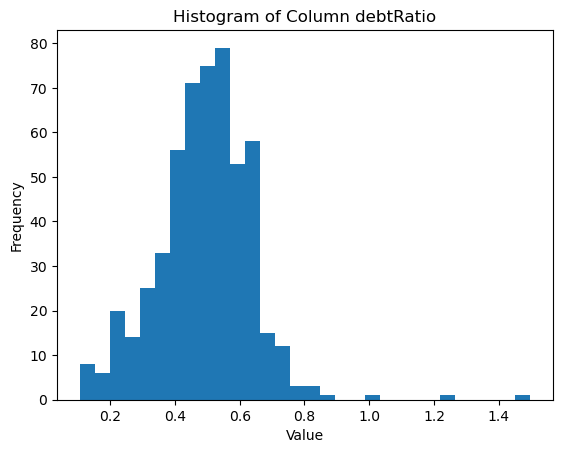


Column shareGrowth might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([ 1.,  0.,  3.,  2.,  2.,  6., 12., 23., 32., 38., 51., 44., 56.,
        60., 51., 47., 33., 18., 17., 12.,  6., 10.,  4.,  2.,  3.,  1.,
         3.,  2.,  0.,  2.]),
 array([-0.25831057, -0.23182427, -0.20533797, -0.17885166, -0.15236536,
        -0.12587906, -0.09939276, -0.07290645, -0.04642015, -0.01993385,
         0.00655245,  0.03303875,  0.05952506,  0.08601136,  0.11249766,
         0.13898396,  0.16547026,  0.19195657,  0.21844287,  0.24492917,
         0.27141547,  0.29790177,  0.32438808,  0.35087438,  0.37736068,
         0.40384698,  0.43033328,  0.45681959,  0.48330589,  0.50979219,
         0.53627849]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column shareGrowth')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

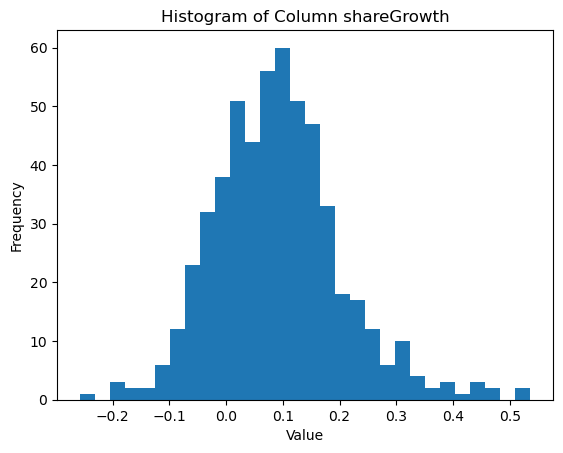

In [12]:
# Calculate variance for each column
variances = numeric_data.var()

# Define thresholds
low_variance_threshold = 0.1

# Identify columns with low variance
low_variance_columns = variances[variances < low_variance_threshold].index.tolist()

for col in numeric_data.columns:
    if col in low_variance_columns:
        print(f"\nColumn {col} might have issues. Inspecting values:")
        
        # Apply signed log transformation to handle both positive and negative values
        transformed_values = np.sign(numeric_data[col]) * np.log1p(np.abs(numeric_data[col]))
        
        plt.figure()
        plt.hist(transformed_values, bins=30)
        plt.title(f'Histogram of Column {col}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.show()

Look for and manage outliers

bookValueperShareGrowth                   535
salesGeneralAndAdministrativeToRevenue    535
ebtPerEbit                                535
sellingAndMarketingExpenses               527
rdexpenseGrowth                           133
totalOtherIncomeExpensesNet               112
otherExpenses                              76
evToFreeCashFlow                           74
priceEarningsToGrowthRatio                 71
priceToFreeCashFlowsRatio                  64
pfcfRatio                                  64
netIncomeGrowth                            63
epsgrowth                                  63
epsdilutedGrowth                           63
priceEarningsRatio                         58
peRatio                                    58
researchAndDevelopmentExpenses             57
fiveYNetIncomeGrowthPerShare               57
freeCashFlowGrowth                         55
ebitgrowth                                 54
dtype: int64

Column bookValueperShareGrowth might have issues. Inspecting value

<Figure size 640x480 with 0 Axes>

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 535.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([-0.5       , -0.46666667, -0.43333333, -0.4       , -0.36666667,
        -0.33333333, -0.3       , -0.26666667, -0.23333333, -0.2       ,
        -0.16666667, -0.13333333, -0.1       , -0.06666667, -0.03333333,
         0.        ,  0.03333333,  0.06666667,  0.1       ,  0.13333333,
         0.16666667,  0.2       ,  0.23333333,  0.26666667,  0.3       ,
         0.33333333,  0.36666667,  0.4       ,  0.43333333,  0.46666667,
         0.5       ]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column bookValueperShareGrowth')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

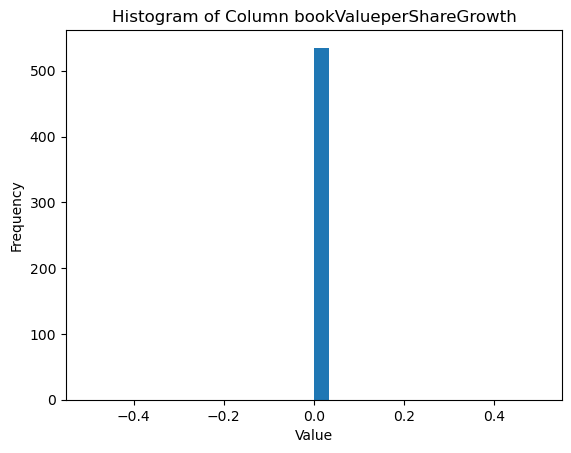


Column salesGeneralAndAdministrativeToRevenue might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([  2.,   0.,   0.,   0.,   0.,   1., 402.,   9.,   5.,  10.,   6.,
          8.,  13.,  14.,   6.,   7.,  10.,   9.,   9.,   2.,   3.,   5.,
          5.,   2.,   3.,   2.,   1.,   0.,   0.,   1.]),
 array([-0.17269201, -0.14790672, -0.12312144, -0.09833615, -0.07355087,
        -0.04876558, -0.0239803 ,  0.00080499,  0.02559027,  0.05037556,
         0.07516084,  0.09994613,  0.12473141,  0.1495167 ,  0.17430198,
         0.19908727,  0.22387255,  0.24865784,  0.27344312,  0.29822841,
         0.32301369,  0.34779898,  0.37258426,  0.39736955,  0.42215484,
         0.44694012,  0.47172541,  0.49651069,  0.52129598,  0.54608126,
         0.57086655]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column salesGeneralAndAdministrativeToRevenue')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

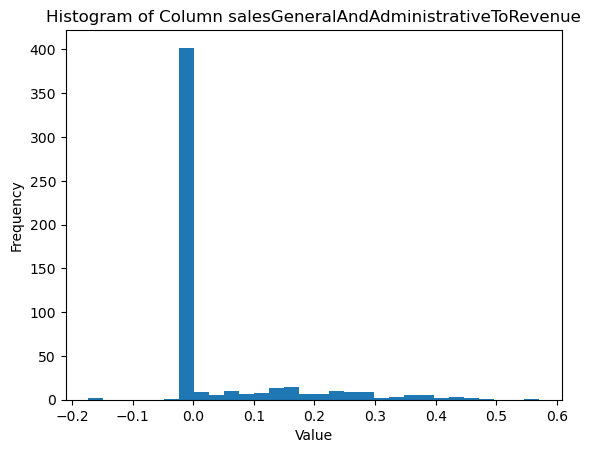


Column ebtPerEbit might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0., 534.]),
 array([0.64783596, 0.64934633, 0.65085671, 0.65236708, 0.65387745,
        0.65538783, 0.6568982 , 0.65840858, 0.65991895, 0.66142932,
        0.6629397 , 0.66445007, 0.66596045, 0.66747082, 0.6689812 ,
        0.67049157, 0.67200194, 0.67351232, 0.67502269, 0.67653307,
        0.67804344, 0.67955381, 0.68106419, 0.68257456, 0.68408494,
        0.68559531, 0.68710568, 0.68861606, 0.69012643, 0.69163681,
        0.69314718]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column ebtPerEbit')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

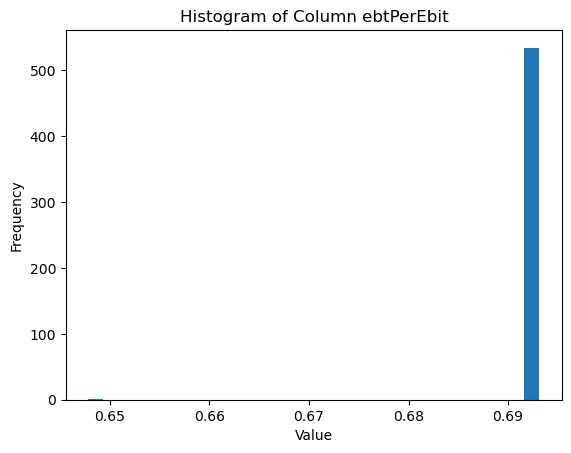


Column sellingAndMarketingExpenses might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([  2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0., 394.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   1.,   4.,  28.,  49.,  31.,  16.]),
 array([-22.85185462, -21.29604725, -19.74023987, -18.1844325 ,
        -16.62862512, -15.07281774, -13.51701037, -11.96120299,
        -10.40539562,  -8.84958824,  -7.29378087,  -5.73797349,
         -4.18216612,  -2.62635874,  -1.07055136,   0.48525601,
          2.04106339,   3.59687076,   5.15267814,   6.70848551,
          8.26429289,   9.82010026,  11.37590764,  12.93171501,
         14.48752239,  16.04332977,  17.59913714,  19.15494452,
         20.71075189,  22.26655927,  23.82236664]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column sellingAndMarketingExpenses')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

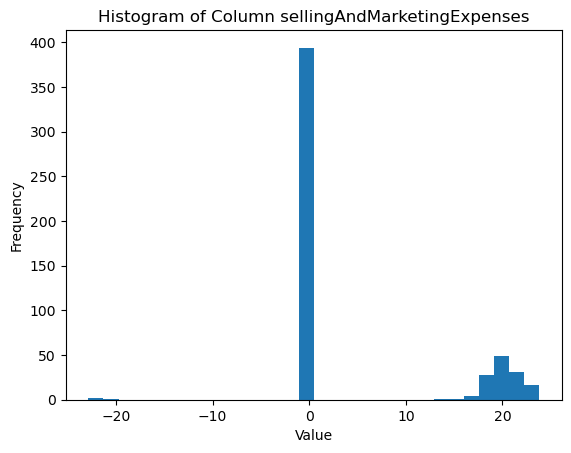


Column rdexpenseGrowth might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([  2.,   0.,   0.,   3.,   1.,   2.,   3.,   4.,   9.,  27., 362.,
         30.,  30.,  18.,  13.,  14.,   4.,   3.,   0.,   1.,   2.,   1.,
          1.,   2.,   1.,   1.,   0.,   0.,   0.,   1.]),
 array([-0.69314718, -0.62637987, -0.55961256, -0.49284525, -0.42607793,
        -0.35931062, -0.29254331, -0.225776  , -0.15900869, -0.09224137,
        -0.02547406,  0.04129325,  0.10806056,  0.17482787,  0.24159519,
         0.3083625 ,  0.37512981,  0.44189712,  0.50866443,  0.57543174,
         0.64219906,  0.70896637,  0.77573368,  0.84250099,  0.9092683 ,
         0.97603562,  1.04280293,  1.10957024,  1.17633755,  1.24310486,
         1.30987217]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column rdexpenseGrowth')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

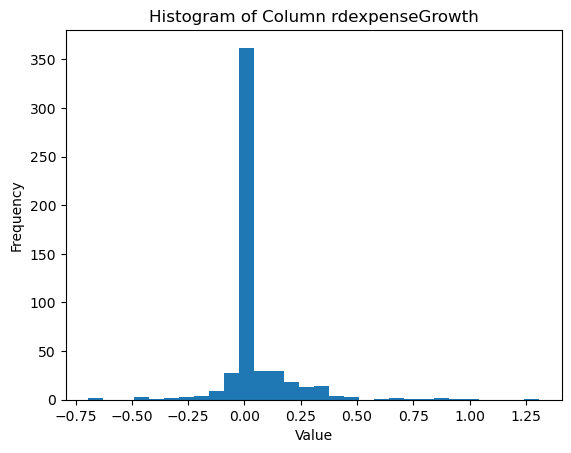


Column totalOtherIncomeExpensesNet might have issues. Inspecting values:


<Figure size 640x480 with 0 Axes>

(array([  1.,   8.,  23.,  45.,  57.,  27.,   7.,   2.,   0.,   0.,   0.,
          0.,   0.,   0., 136.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         17.,  37.,  60.,  62.,  32.,  10.,   2.,   1.]),
 array([-23.1683049 , -21.56241716, -19.95652943, -18.35064169,
        -16.74475396, -15.13886622, -13.53297848, -11.92709075,
        -10.32120301,  -8.71531528,  -7.10942754,  -5.50353981,
         -3.89765207,  -2.29176433,  -0.6858766 ,   0.92001114,
          2.52589887,   4.13178661,   5.73767434,   7.34356208,
          8.94944982,  10.55533755,  12.16122529,  13.76711302,
         15.37300076,  16.97888849,  18.58477623,  20.19066397,
         21.7965517 ,  23.40243944,  25.00832717]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of Column totalOtherIncomeExpensesNet')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

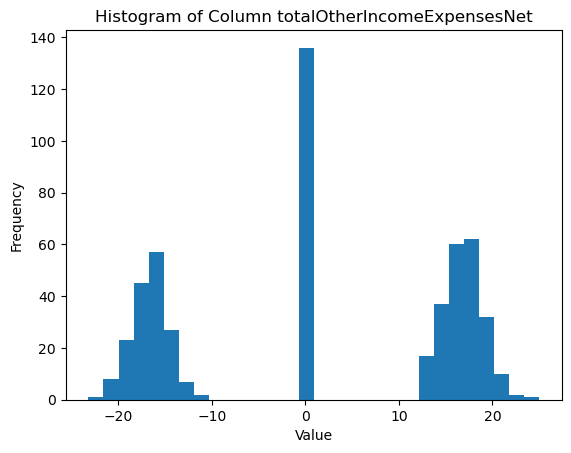

In [23]:
#Examine the data further for outliers
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for each column
Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

outliers = (numeric_data <= lower_bound) | (numeric_data >= upper_bound)

# Count the number of outliers in each column
outliers_count = outliers.sum()

# Sort the columns by the number of outliers in descending order
sorted_outliers = outliers_count.sort_values(ascending=False)

print(sorted_outliers.head(20))  

for col in sorted_outliers.index:
    if sorted_outliers[col] > 100:
        
        # Apply signed log transformation to handle both positive and negative values
        transformed_values = np.sign(numeric_data[col]) * np.log1p(np.abs(numeric_data[col]))
        
        print(f"\nColumn {col} might have issues. Inspecting values:")
        plt.figure()
        plt.hist(transformed_values, bins=30)
        plt.title(f'Histogram of Column {col}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.show()
       

In [ ]:
#Cap the outliers but exclude sellingAndMarketingExpenses as it has zero expenses and then a range
def cap_outliers(data, quantile_range=(0.01, 0.99), exclude_columns=['year', 'sellingAndMarketingExpenses']):
    # Copy the DataFrame to avoid modifying the original data
    capped_df = data.copy()
    
    for column in data.columns:
        if column not in exclude_columns and pd.api.types.is_numeric_dtype(data[column]):
            lower_quantile, upper_quantile = data[column].quantile(quantile_range).values
            capped_df[column] = data[column].clip(lower=lower_bound, upper=upper_bound)
    
    return capped_df

In [15]:
#Check the data frame
data

,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,tangibleBookValuePerShare,shareholdersEquityPerShare,interestDebtPerShare,marketCap,...,priceToBookRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,enterpriseValueMultiple,priceFairValue,shareGrowth
symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,13.9911,2.9714,3.7316,3.1672,2.6266,4.8661,18.2040,4.8661,5.4509,1.157812e+12,...,12.7952,20.9536,19.6586,16.6853,16.6853,7.0516,4.4501,14.7417,12.7952,0.307494
MSFT,16.4008,5.1140,6.8011,4.9863,1.4800,13.3364,30.8589,13.3364,9.8534,1.061250e+12,...,10.3709,27.0451,27.7378,20.3363,20.3363,5.2884,8.4331,19.3402,10.3709,0.150507
AMZN,556.5913,22.9921,76.4167,42.9623,71.6111,123.1349,409.6131,123.1349,83.5496,9.428228e+11,...,15.1921,81.3620,43.5424,24.4800,24.4800,4.0709,3.3610,25.3605,15.1921,0.064639
FB,24.5817,6.4273,12.6266,7.3755,6.6339,35.1370,39.5574,35.1370,0.1523,6.026083e+11,...,5.9632,32.5999,28.4088,16.5944,16.5944,4.2401,8.5238,19.1001,5.9632,0.167454
GOOGL,231.7023,49.1628,78.0467,44.3372,26.4803,288.3692,362.6137,288.3692,6.6623,1.015875e+12,...,5.0430,29.5803,32.7998,18.6331,18.6331,0.6723,6.2764,19.4527,5.0430,0.110605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RE,181.4979,24.7834,45.4687,45.4687,19.8382,224.2236,670.8363,224.2236,16.3394,1.104050e+10,...,1.2089,10.9370,5.9614,5.9614,5.9614,5.0031,1.4934,9.6104,1.2089,0.049232
SNA,72.7674,12.4061,12.0680,10.2898,3.3005,60.9857,81.1413,60.9857,19.3953,9.011158e+09,...,2.6433,12.9937,15.6661,13.3578,13.3578,1.0474,2.2153,10.4984,2.6433,0.094457
SNA,73.9582,12.6091,12.2655,10.4582,3.3545,61.9836,82.4691,61.9836,21.9782,8.763860e+09,...,2.5707,12.6371,15.2362,12.9912,12.9912,1.0022,2.1545,9.3046,2.5707,0.094457


Fill in missing values using Linear Regression

In [16]:
lr = LinearRegression()

for column in data.columns:
    if data[column].isnull().any():  # Check if there are any missing values in the column
        # Split the data into training and testing datasets based on the presence of null values in the column
        testdf = data[data[column].isnull()]
        traindf = data[data[column].notnull()]

        # Separate the target variable from the training dataset
        y = traindf[column]
        traindf_features = traindf.drop(column, axis=1)
        testdf_features = testdf.drop(column, axis=1)

        # Impute missing values in the features
        imputer = SimpleImputer(strategy='mean')
        traindf_features = imputer.fit_transform(traindf_features)
        testdf_features = imputer.transform(testdf_features)

        # Fit the linear regression model
        lr.fit(traindf_features, y)

        # Predict missing values for the target column
        pred = lr.predict(testdf_features)

        # Assign the predicted values back to the original DataFrame
        data.loc[data[column].isnull(), column] = pred

        
        
data
data.isnull().sum()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,tangibleBookValuePerShare,shareholdersEquityPerShare,interestDebtPerShare,marketCap,...,priceToBookRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,enterpriseValueMultiple,priceFairValue,shareGrowth
symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,13.9911,2.9714,3.7316,3.1672,2.6266,4.8661,18.2040,4.8661,5.4509,1.157812e+12,...,12.7952,20.9536,19.6586,16.6853,16.6853,7.0516,4.4501,14.7417,12.7952,0.307494
MSFT,16.4008,5.1140,6.8011,4.9863,1.4800,13.3364,30.8589,13.3364,9.8534,1.061250e+12,...,10.3709,27.0451,27.7378,20.3363,20.3363,5.2884,8.4331,19.3402,10.3709,0.150507
AMZN,556.5913,22.9921,76.4167,42.9623,71.6111,123.1349,409.6131,123.1349,83.5496,9.428228e+11,...,15.1921,81.3620,43.5424,24.4800,24.4800,4.0709,3.3610,25.3605,15.1921,0.064639
FB,24.5817,6.4273,12.6266,7.3755,6.6339,35.1370,39.5574,35.1370,0.1523,6.026083e+11,...,5.9632,32.5999,28.4088,16.5944,16.5944,4.2401,8.5238,19.1001,5.9632,0.167454
GOOGL,231.7023,49.1628,78.0467,44.3372,26.4803,288.3692,362.6137,288.3692,6.6623,1.015875e+12,...,5.0430,29.5803,32.7998,18.6331,18.6331,0.6723,6.2764,19.4527,5.0430,0.110605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RE,181.4979,24.7834,45.4687,45.4687,19.8382,224.2236,670.8363,224.2236,16.3394,1.104050e+10,...,1.2089,10.9370,5.9614,5.9614,5.9614,5.0031,1.4934,9.6104,1.2089,0.049232
SNA,72.7674,12.4061,12.0680,10.2898,3.3005,60.9857,81.1413,60.9857,19.3953,9.011158e+09,...,2.6433,12.9937,15.6661,13.3578,13.3578,1.0474,2.2153,10.4984,2.6433,0.094457
SNA,73.9582,12.6091,12.2655,10.4582,3.3545,61.9836,82.4691,61.9836,21.9782,8.763860e+09,...,2.5707,12.6371,15.2362,12.9912,12.9912,1.0022,2.1545,9.3046,2.5707,0.094457


revenuePerShare               0
netIncomePerShare             0
operatingCashFlowPerShare     0
freeCashFlowPerShare          0
cashPerShare                  0
                             ..
priceEarningsToGrowthRatio    0
priceSalesRatio               0
enterpriseValueMultiple       0
priceFairValue                0
shareGrowth                   0
Length: 155, dtype: int64

Check for strong correlations between columns

In [17]:
# Calculate the correlation matrix for the entire DataFrame
correlation_matrix = data.corr()

# Ensure the correlation matrix has no NaN values
correlation_matrix = correlation_matrix.fillna(0)

# Convert correlation matrix to a distance matrix
distance_matrix = 1 - np.abs(correlation_matrix)

# Ensure the distance matrix has no NaN values
distance_matrix = distance_matrix.fillna(1)

# Perform hierarchical clustering
Z = linkage(distance_matrix, method='complete')

# Define a threshold to form flat clusters
correlation_threshold = 0.999
clusters = fcluster(Z, correlation_threshold, criterion='distance')

# Create a DataFrame to show the clusters
clustered_columns = pd.DataFrame({'Column': data.columns, 'Cluster': clusters})
clustered_columns = clustered_columns.sort_values(by='Cluster')

# Print detailed cluster information
for cluster in np.unique(clusters):
    cluster_group = clustered_columns[clustered_columns['Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(cluster_group['Column'].tolist())
    
data


Cluster 1:
['marketCap', 'enterpriseValue']

Cluster 2:
['evToSales', 'priceEarningsToGrowthRatio', 'priceSalesRatio', 'enterpriseValueMultiple', 'priceBookValueRatio', 'evToFreeCashFlow', 'evToOperatingCashFlow', 'enterpriseValueOverEBITDA', 'priceToBookRatio', 'ptbRatio', 'pbRatio', 'priceCashFlowRatio', 'pfcfRatio', 'priceToSalesRatio', 'peRatio', 'dividendPayoutRatio', 'dividendPaidAndCapexCoverageRatio', 'dividendYield', 'priceFairValue', 'priceToFreeCashFlowsRatio', 'priceEarningsRatio', 'pocfratio', 'priceToOperatingCashFlowsRatio']

Cluster 3:
['tangibleBookValuePerShare', 'earningsYield']

Cluster 4:
['grahamNetNet', 'netIncomePerShare']

Cluster 5:
['ebitgrowth', 'operatingIncomeGrowth']

Cluster 6:
['totalOtherIncomeExpensesNet', 'epsdiluted', 'receivablesTurnover', 'grahamNumber', 'longTermDebtToCapitalization', 'operatingCashFlowPerShare', 'bookValuePerShare', 'shareholdersEquityPerShare', 'eps']

Cluster 7:
['averageReceivables']

Cluster 8:
['incomeBeforeTax', 'ebitda',

/var/folders/v3/1q4y382n3s7cs7l8hpc7z7_r0000gp/T/ipykernel_81448/227287547.py:14: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete')


,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,tangibleBookValuePerShare,shareholdersEquityPerShare,interestDebtPerShare,marketCap,...,priceToBookRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,enterpriseValueMultiple,priceFairValue,shareGrowth
symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,13.9911,2.9714,3.7316,3.1672,2.6266,4.8661,18.2040,4.8661,5.4509,1.157812e+12,...,12.7952,20.9536,19.6586,16.6853,16.6853,7.0516,4.4501,14.7417,12.7952,0.307494
MSFT,16.4008,5.1140,6.8011,4.9863,1.4800,13.3364,30.8589,13.3364,9.8534,1.061250e+12,...,10.3709,27.0451,27.7378,20.3363,20.3363,5.2884,8.4331,19.3402,10.3709,0.150507
AMZN,556.5913,22.9921,76.4167,42.9623,71.6111,123.1349,409.6131,123.1349,83.5496,9.428228e+11,...,15.1921,81.3620,43.5424,24.4800,24.4800,4.0709,3.3610,25.3605,15.1921,0.064639
FB,24.5817,6.4273,12.6266,7.3755,6.6339,35.1370,39.5574,35.1370,0.1523,6.026083e+11,...,5.9632,32.5999,28.4088,16.5944,16.5944,4.2401,8.5238,19.1001,5.9632,0.167454
GOOGL,231.7023,49.1628,78.0467,44.3372,26.4803,288.3692,362.6137,288.3692,6.6623,1.015875e+12,...,5.0430,29.5803,32.7998,18.6331,18.6331,0.6723,6.2764,19.4527,5.0430,0.110605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RE,181.4979,24.7834,45.4687,45.4687,19.8382,224.2236,670.8363,224.2236,16.3394,1.104050e+10,...,1.2089,10.9370,5.9614,5.9614,5.9614,5.0031,1.4934,9.6104,1.2089,0.049232
SNA,72.7674,12.4061,12.0680,10.2898,3.3005,60.9857,81.1413,60.9857,19.3953,9.011158e+09,...,2.6433,12.9937,15.6661,13.3578,13.3578,1.0474,2.2153,10.4984,2.6433,0.094457
SNA,73.9582,12.6091,12.2655,10.4582,3.3545,61.9836,82.4691,61.9836,21.9782,8.763860e+09,...,2.5707,12.6371,15.2362,12.9912,12.9912,1.0022,2.1545,9.3046,2.5707,0.094457


Drop columns that are stongly correlated and or similiar business measurements

In [18]:
# Drop columns clusters 1-10 
data.drop(columns=['marketCap',
                   'threeYShareholdersEquityGrowthPerShare', 'threeYNetIncomeGrowthPerShare', 
                   'threeYRevenueGrowthPerShare', 'threeYOperatingCFGrowthPerShare','fiveYRevenueGrowthPerShare',
                   'fiveYNetIncomeGrowthPerShare', 'fiveYOperatingCFGrowthPerShare', 'fiveYDividendperShareGrowthPerShare',
                   'returnOnTangibleAssets', 'roic', 'returnOnCapitalEmployed',
                   ], inplace=True)

# Drop columns clusters 11-20
data.drop(columns= ['stockBasedCompensationToRevenue', 'researchAndDdevelopementToRevenue', 'operatingCashFlowSalesRatio', 
                    'ebitPerRevenue', 'pretaxProfitMargin', 'operatingProfitMargin', 'capexToDepreciation', 'capexToRevenue', 
                    'capexToOperatingCashFlow','netCurrentAssetValue','daysOfInventoryOutstanding', 'daysOfInventoryOnHand',
                   'daysPayablesOutstanding','daysOfPayablesOutstanding','grossProfit'], inplace=True)

# Drop columns clusters 21-30
data.drop(columns= ['roe', 'debtToEquity', 'companyEquityMultiplier','operatingIncomeRatio', 'incomeBeforeTaxRatio', 'ebitdaratio',
                   'assetTurnover', 'payablesTurnover', 'epsdilutedGrowth', 'netIncomeGrowth','debtToAssets','cashRatio'
                   ], inplace=True)

# Drop columns cluster 31-40
data.drop(columns= ['dividendPayoutRatio', 'operatingIncomeGrowth', 'daysOfSalesOutstanding', 'netIncomePerEBT'], inplace=True)
          
# Drop columns cluster 41-67
data.drop(columns= ['revenue', 'depreciationAndAmortization', 'costAndExpenses','incomeBeforeTax', 'cashPerShare', 
                    'operatingCashFlowPerShare', 'freeCashFlowPerShare', 'grahamNetNet', 'shareholdersEquityPerShare', 'tangibleBookValuePerShare', 'bookValuePerShare', 
                   'grahamNumber', 'netIncomePerShare', 'capexPerShare', 'earningsYield', 'epsdiluted',
                    ], inplace=True)          


In [19]:
#check the data fram and ensure no NaNs for machine learning
data

data.isnull().sum()

,revenuePerShare,interestDebtPerShare,enterpriseValue,peRatio,priceToSalesRatio,pocfratio,pfcfRatio,pbRatio,ptbRatio,evToSales,...,priceToBookRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,enterpriseValueMultiple,priceFairValue,shareGrowth
symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,13.9911,5.4509,1.206755e+12,20.9536,4.4501,16.6853,19.6586,12.7952,12.7952,4.6383,...,12.7952,20.9536,19.6586,16.6853,16.6853,7.0516,4.4501,14.7417,12.7952,0.307494
MSFT,16.4008,9.8534,1.122813e+12,27.0451,8.4331,20.3363,27.7378,10.3709,10.3709,8.9223,...,10.3709,27.0451,27.7378,20.3363,20.3363,5.2884,8.4331,19.3402,10.3709,0.150507
AMZN,556.5913,83.5496,9.472398e+11,81.3620,3.3610,24.4800,43.5424,15.1921,15.1921,3.3767,...,15.1921,81.3620,43.5424,24.4800,24.4800,4.0709,3.3610,25.3605,15.1921,0.064639
FB,24.5817,0.1523,5.839473e+11,32.5999,8.5238,16.5944,28.4088,5.9632,5.9632,8.2599,...,5.9632,32.5999,28.4088,16.5944,16.5944,4.2401,8.5238,19.1001,5.9632,0.167454
GOOGL,231.7023,6.6623,1.001931e+12,29.5803,6.2764,18.6331,32.7998,5.0430,5.0430,6.1902,...,5.0430,29.5803,32.7998,18.6331,18.6331,0.6723,6.2764,19.4527,5.0430,0.110605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RE,181.4979,16.3394,1.086629e+10,10.9370,1.4934,5.9614,5.9614,1.2089,1.2089,1.4699,...,1.2089,10.9370,5.9614,5.9614,5.9614,5.0031,1.4934,9.6104,1.2089,0.049232
SNA,72.7674,19.3953,9.959858e+09,12.9937,2.2153,13.3578,15.6661,2.6433,2.6433,2.4485,...,2.6433,12.9937,15.6661,13.3578,13.3578,1.0474,2.2153,10.4984,2.6433,0.094457
SNA,73.9582,21.9782,9.739160e+09,12.6371,2.1545,12.9912,15.2362,2.5707,2.5707,2.3943,...,2.5707,12.6371,15.2362,12.9912,12.9912,1.0022,2.1545,9.3046,2.5707,0.094457


revenuePerShare               0
interestDebtPerShare          0
enterpriseValue               0
peRatio                       0
priceToSalesRatio             0
                             ..
priceEarningsToGrowthRatio    0
priceSalesRatio               0
enterpriseValueMultiple       0
priceFairValue                0
shareGrowth                   0
Length: 96, dtype: int64

Export for machine learning

In [20]:
# Set the index name
data.index.name = 'symbol'

# Export the DataFrame with the unique index
data.to_csv('data/data.csv', index=True)